## Script to fit isochrones for ARMADA binaries

#### - We know delta mag in a few bands from speckle or WDS. We know delta mag in H/K bands from interferometry. We know total magnitudes in many bands from literature.
#### - In theory, we know distance from Hipparcos or Gaia (this is weakest point, as they are unresolved binaries!)

#### - Compare photometry to models using isochrones package

###### The python isochrones package is needed to run this notebook: https://isochrones.readthedocs.io/en/latest/
###### As suggested in the user guide, I prefer installing isochrones in a separate conda environment. Hence, this environment needs to be activated before running jupyter lab

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import random
from astroquery.simbad import Simbad
from uncertainties import ufloat,unumpy
from uncertainties.umath import *
import pandas as pd
import csv


from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone
Mist_iso = MIST_Isochrone()
Mist_evoTrack = MIST_EvolutionTrack()

%matplotlib inline

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 5)
matplotlib.rcParams['font.family'] = "Times New Roman"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.markerfacecolor'] = 'black'
matplotlib.rcParams['lines.linewidth'] = 3.5

In [3]:
## Add quantities of interest to Simbad query -- for total magnitudes
##
## This is a good first check, but for for each target we will eventually 
## want to do a deeper literature search to make sure we are using 
## all available photometry. We should record this in the spreadsheet.

Simbad.add_votable_fields('flux(U)')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('flux(V)')
Simbad.add_votable_fields('flux(G)')
Simbad.add_votable_fields('flux(R)')
Simbad.add_votable_fields('flux(I)')
Simbad.add_votable_fields('flux(J)')
Simbad.add_votable_fields('flux(H)')
Simbad.add_votable_fields('flux(K)')

Simbad.add_votable_fields('flux_error(U)')
Simbad.add_votable_fields('flux_error(B)')
Simbad.add_votable_fields('flux_error(V)')
Simbad.add_votable_fields('flux_error(G)')
Simbad.add_votable_fields('flux_error(R)')
Simbad.add_votable_fields('flux_error(I)')
Simbad.add_votable_fields('flux_error(J)')
Simbad.add_votable_fields('flux_error(H)')
Simbad.add_votable_fields('flux_error(K)')

In [4]:
## Setup paths
dirpath = "/Users/suzutsuki-ch/Work/ARMADA/"
save_directory = "/Users/suzutsuki-ch/Work/ARMADA/Targets" ## path for saved files
armada_file = "/Users/suzutsuki-ch/Work/ARMADA/full_target_list.csv" ## path to csv target file
note = 'Chi' ## note for saved files (e.g. 'hip' for hipparcos distance, or 'gaia')

## First select a binary target and get info from csv file

In this part, user can specify a target and query from simbad to obtain its total apparent magnitude. With the measured flux ratio, user can split the total observed magnitude in a system to separate magnitudes of individual stars. The formula is given below.
$$\Delta M = -2.5\log_{10}(f_1/f_2)~~~\Rightarrow~~~f_1 = 10^{-0.4\Delta M}f_2$$
Let $m$ be the total apparent magnitude queried from simbad, we can calculate apparent magnitude $m_1$, $m_2$ for individual targets.
$$m_1 = m-2.5\log_{10}\frac{f_1+f_2}{f_1}$$
$$m_2 = m-2.5\log_{10}\frac{f_1+f_2}{f_2}$$
To convert everything to absolute magnitude, we subtract distance modulus from the results:
$$M_i = m_i - 5\log_{10}(d/10pc)$$
We assume no extinction, and the two stars are of equal distance to us.

Note that we will likely fit to observables (i.e. total magnitude and flux ratios)

In [5]:
target_hd = '6456'
df = pd.read_csv(armada_file,dtype=object)

## Create directory for saved files, if it doesn't already exist
directory = "%s/HD_%s/"%(save_directory,target_hd)
if not os.path.exists(directory):
    print("Creating directory")
    os.makedirs(directory)

In [6]:
idx = np.where(df['HD']==target_hd)[0][0]

distance_gaia = ufloat(float(df['Gaia_distance (pc)'][idx]),float(df['Gaia_distance_err (pc)'][idx]))
distance_hip = ufloat(float(df['HIP_distance (pc)'][idx]),float(df['HIP_distance_err (pc)'][idx]))
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)


cdiff_h = ufloat(float(df['dmag_h'][idx]),float(df['dmag_h_err'][idx]))
cdiff_k = ufloat(float(df['dmag_k'][idx]),float(df['dmag_k_err'][idx]))
cdiff_i = ufloat(float(df['dmag_speckle_i'][idx]),float(df['dmag_speckle_i_err'][idx]))
cdiff_v_speckle = ufloat(float(df['dmag_speckle_v'][idx]),float(df['dmag_speckle_v_err'][idx]))
cdiff_v_wds = ufloat(float(df['dmag_wds_v'][idx]),float(df['dmag_wds_v_err'][idx]))

distance gaia =  nan+/-nan
distance hip =  84+/-5


In [7]:
cdiff_k = ufloat(0.43,0.1)
#cdiff_h = ufloat(np.nan,np.nan)

In [8]:
fratio_h = 10**(cdiff_h/2.5)
fratio_k = 10**(cdiff_k/2.5)
fratio_i = 10**(cdiff_i/2.5)
fratio_v_speckle = 10**(cdiff_v_speckle/2.5)
fratio_v_wds = 10**(cdiff_v_wds/2.5)

print("fratio: v_speckle, v_wds, i_mag, h_mag, k_mag = ")
print(fratio_v_speckle,',',fratio_v_wds,',',fratio_i,',',fratio_h,',',fratio_k)

fratio: v_speckle, v_wds, i_mag, h_mag, k_mag = 
2.11+/-0.29 , 2.2+/-0.5 , 1.91+/-0.26 , 2.1+/-0.4 , 1.49+/-0.14


In [9]:
## choose which distance to use -- not necessarily obvious! We may want to compare both
# distance = distance_hip
# Choosing a new distance form kervella catalogue
distance = ufloat(87.9, 0.68)

**Calculate the total dynamical mass using the Kervella catalogue**

In [10]:
# df.columns

In [11]:
a_rad = ufloat(float(df['a (mas)'][idx]),float(df['a_err (mas)'][idx]))/1000/206264.806247
a_au = (distance*a_rad)*206264.806
P_yr = ufloat(float(df['P (yr)'][idx]),float(df['P_err (yr)'][idx]))
M_dyn = a_au**3/P_yr**2
print("dynamical mass: %.4f +/- %.4f " % (M_dyn.n, M_dyn.s))

dynamical mass: 4.9639 +/- 0.1161 


## Generating SED for individual components

In [12]:
## query total magnitudes and errors from Simbad
query = Simbad.query_object('HD %s'%target_hd)

ktot = ufloat(query['FLUX_K'][0],query['FLUX_ERROR_K'][0])
utot = ufloat(query['FLUX_U'][0],query['FLUX_ERROR_U'][0])
btot = ufloat(query['FLUX_B'][0],query['FLUX_ERROR_B'][0])
rtot = ufloat(query['FLUX_R'][0],query['FLUX_ERROR_R'][0])
itot = ufloat(query['FLUX_I'][0],query['FLUX_ERROR_I'][0])
htot = ufloat(query['FLUX_H'][0],query['FLUX_ERROR_H'][0])
jtot = ufloat(query['FLUX_J'][0],query['FLUX_ERROR_J'][0])
vtot = ufloat(query['FLUX_V'][0],query['FLUX_ERROR_V'][0])
gtot = ufloat(query['FLUX_G'][0],query['FLUX_ERROR_G'][0])


print("U,B,V,R,Gaia_G,I,J,H,K = ")
print(utot,',',btot,',',vtot,',',rtot,',',gtot,',',itot,',',jtot,',',htot,',',ktot)

U,B,V,R,Gaia_G,I,J,H,K = 
5.260000228881836+/-nan , 5.263+/-0.014 , 5.273+/-0.009 , nan+/-nan , 5.268+/-0.006 , nan+/-nan , 5.24+/-0.05 , 5.301+/-0.021 , 5.265+/-0.027


/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)
/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)


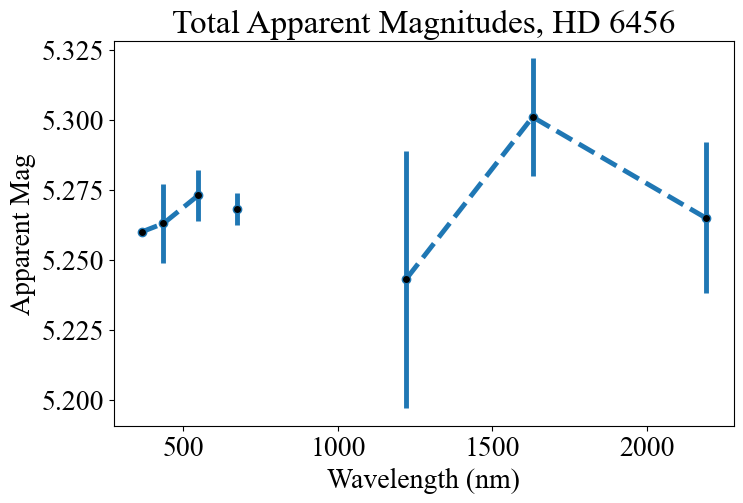

In [13]:
x = np.array([2190,1630,1220,832,673,658,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,itot.nominal_value,
              gtot.nominal_value,rtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])
yerr = np.array([ktot.std_dev,htot.std_dev,jtot.std_dev,itot.std_dev,gtot.std_dev,
                 rtot.std_dev,vtot.std_dev,btot.std_dev,utot.std_dev])

plt.title("Total Apparent Magnitudes, HD %s"%target_hd)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Apparent Mag")
plt.errorbar(x,y,yerr,fmt='o--')
plt.savefig("%s/HD_%s_%s_total_mags.pdf"%(directory,target_hd,note), transparent=True)
plt.show()

In [14]:
x_notnan = np.array([2190,1630,1220,673,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y_notnan = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,gtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])

In [15]:
data_wave = np.array([551,562,832,1630,2190]) ## wavelengths of our speckle + interferometry data, CHECK THESE

## Compute individual magnitudes from flux ratios and total magnitudes
## Mostly for plotting. We probably won't fit to these in the end. 

k1 = -2.5*log10(10**(-ktot/2.5)/(1+10**(-cdiff_k/2.5)))
k2 = cdiff_k + k1

h1 = -2.5*log10(10**(-htot/2.5)/(1+10**(-cdiff_h/2.5)))
h2 = cdiff_h + h1

# This line is for visualizing the SED. 
# Though Gaia G does have some overlap with speckle_i, I believe we should not use this in fitting
i1 = -2.5*log10(10**(-gtot/2.5)/(1+10**(-cdiff_i/2.5)))
i2 = cdiff_i + i1

v_speckle1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v_speckle/2.5)))
v_speckle2 = cdiff_v_speckle + v_speckle1

v_wds1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v_wds/2.5)))
v_wds2 = cdiff_v_wds + v_wds1

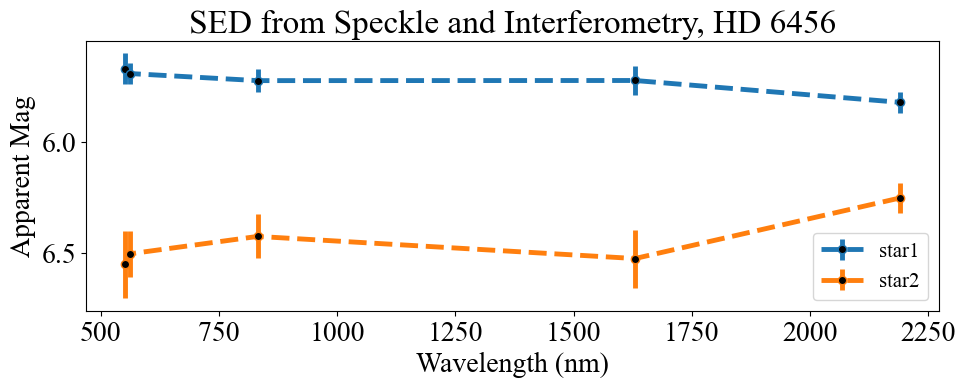

In [16]:
p1 = np.array([v_wds1.nominal_value,v_speckle1.nominal_value,i1.nominal_value,h1.nominal_value,k1.nominal_value])
p1err = np.array([v_wds1.std_dev,v_speckle1.std_dev,i1.std_dev,h1.std_dev,k1.std_dev])
p2 = np.array([v_wds2.nominal_value,v_speckle2.nominal_value,i2.nominal_value,h2.nominal_value,k2.nominal_value])
p2err = np.array([v_wds2.std_dev,v_speckle2.std_dev,i2.std_dev,h2.std_dev,k2.std_dev])

plt.figure(figsize=(11,3.5))
plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--', label="star1")
plt.errorbar(data_wave,p2,p2err,fmt='o--', label="star2")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,note), dpi=240, bbox_inches="tight", transparent=True)
plt.show()

## Now we want to use this information to fit isochrones

#### Generate tracks of multiple ages at chosen metallicity

In [17]:
import tqdm

In [18]:
# This cell fails at its initial run, please run it again if error is thrown

feh = -0.46 ## we will want to look up this value for each target
Av = 0.0 ## targets are nearby, so extinction should be negligible

log_age_start = 6 ## starting age
log_age_size = 0.5 ## step size
log_age_steps = 7 ## number of steps

try:
    paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

    isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
    isoList[0].head()
except:
    paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

    isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
    isoList[0].head()

/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/suzutsuki-ch/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/isochrones/models.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf.loc[:, "dm_deep"] = deriv


#### We need to add B, V, and I mag to the output of isochrones (H and K included by default)
#### Using bolometric correction grid to compute these model magnitudes

In [19]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])

In [20]:
# Check first few rows of bolometric correction grid
bc_grid_B.df.head()
#bc_grid_V.df.head()
#bc_grid_I.df.head()

B
Teff   logg [Fe/H] Av            
2500.0 -4.0 -4.0   0.00 -7.714880
                   0.05 -7.773749
                   0.10 -7.832595
                   0.15 -7.891418
                   0.20 -7.950218

In [21]:
# Calculating the bolometric correction in B band
Mbol_B = []
for i,iso in enumerate(isoList):
    Mbol_B.append(bc_grid_B.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())   
B = []
for i,iso in enumerate(isoList):
    B.append(iso['Mbol'] - Mbol_B[i])
    
# Calculating the bolometric correction in V band
Mbol_V = []
for i,iso in enumerate(isoList):
    Mbol_V.append(bc_grid_V.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
V = []
for i,iso in enumerate(isoList):
    V.append(iso['Mbol'] - Mbol_V[i])

# Calculating the bolometric correction in I band
Mbol_I = []
for i,iso in enumerate(isoList):
    Mbol_I.append(bc_grid_I.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
I = []
for i,iso in enumerate(isoList):
    I.append(iso['Mbol'] - Mbol_I[i])
    
H = []
for iso in isoList:
    H.append(iso['H_mag'])

K = []
for iso in isoList:
    K.append(iso['K_mag'])

## Let's take a look at the HR diagram
#### No fitting at this point, but good to estimate starting value for age

In [22]:
print("Distance = ", distance, 'pc')
d_modulus = 5*log10(distance)-5
print("Distance Modulus = ", d_modulus)

Distance =  87.9+/-0.7 pc
Distance Modulus =  4.720+/-0.017


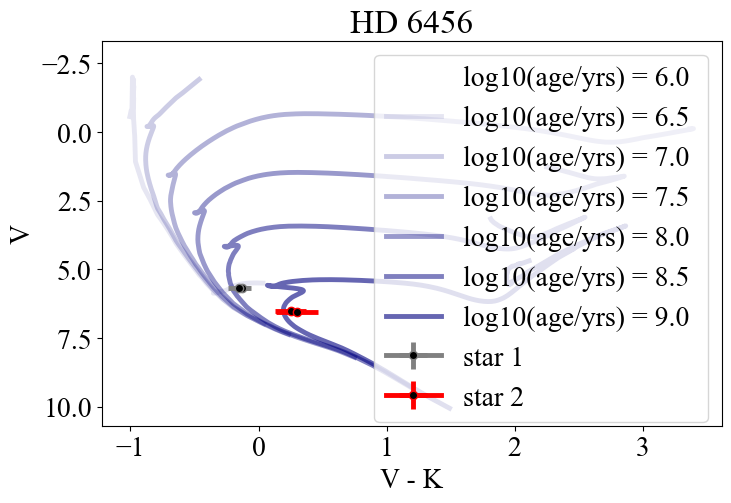

In [23]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500

## Choose x/y axis. For example, V-H vs V
xval1 =v_speckle1-k1 ## component 1
yval1 = v_speckle1
xval2 = v_speckle2-k2 ## component 2
yval2 = v_speckle2

xval3 =v_wds1-k1 ## component 1
yval3 = v_wds1
xval4 = v_wds2-k2 ## component 2
yval4 = v_wds2

xlabel = "V - K"
ylabel = "V"

for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - K[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6+0.5*i} ", color="navy", alpha=1 - (1 - 0.1*i))

## make plot
plt.errorbar([xval1.nominal_value,xval3.nominal_value],[yval1.nominal_value, yval3.nominal_value],
             xerr = [xval1.std_dev,xval3.std_dev], yerr = [yval1.std_dev,yval3.std_dev],
             color="gray", label="star 1", markerfacecolor="black",marker='o')
plt.errorbar([xval2.nominal_value,xval4.nominal_value],[yval2.nominal_value, yval4.nominal_value],
             xerr = [xval2.std_dev,xval4.std_dev], yerr = [yval2.std_dev,yval4.std_dev],
             color="red", label="star 2", markerfacecolor="black",marker='o')


        
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.gca().invert_yaxis()
plt.title("HD %s"%target_hd)
plt.legend()
plt.savefig("%s/HD_%s_%s_hr_diagram.png"%(directory,target_hd,note))
plt.show()

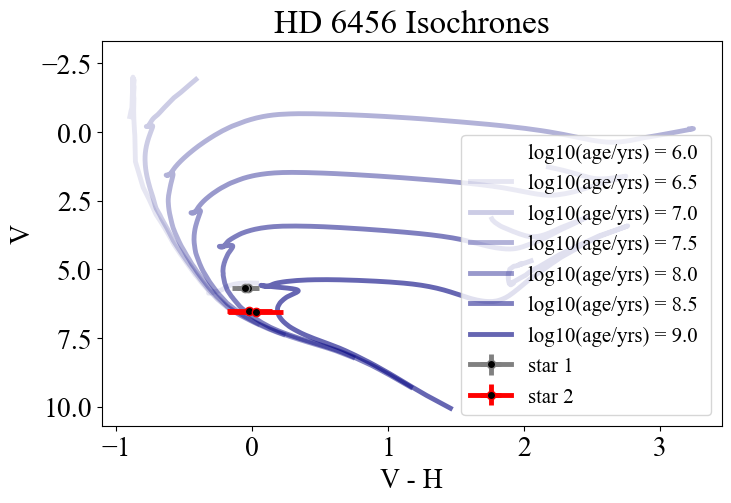

In [24]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500


## Choose x/y axis. For example, V-H vs V
xval1 =v_speckle1-h1 ## component 1
yval1 = v_speckle1
xval2 = v_speckle2-h2 ## component 2
yval2 = v_speckle2

xval3 =v_wds1-h1 ## component 1
yval3 = v_wds1
xval4 = v_wds2-h2 ## component 2
yval4 = v_wds2

xlabel = "V - H"
ylabel = "V"

plt.figure(facecolor="None")
for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - H[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6+0.5*i} ", color="navy", alpha=1 - (1 - 0.1*i))

## make plot

plt.errorbar([xval1.nominal_value,xval3.nominal_value],[yval1.nominal_value, yval3.nominal_value],
             xerr = [xval1.std_dev,xval3.std_dev], yerr = [yval1.std_dev,yval3.std_dev],
             color="gray", label="star 1", markerfacecolor="black",marker='o')
plt.errorbar([xval2.nominal_value,xval4.nominal_value],[yval2.nominal_value, yval4.nominal_value],
             xerr = [xval2.std_dev,xval4.std_dev], yerr = [yval2.std_dev,yval4.std_dev],
             color="red", label="star 2", markerfacecolor="black",marker='o')

        
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.gca().invert_yaxis()
plt.title("HD %s Isochrones"%target_hd)
plt.legend(fontsize=15,loc=4)
plt.savefig("%s/HD_%s_%s_hr_diagram.png"%(directory,target_hd,note), dpi=240, bbox_inches="tight")
plt.show()

## Now let's do a MCMC fit for masses and age

In the fitting, the likelihood function is given by:
$$\mathcal{L} = \exp\left(-\frac{1}{2}\sum_i \left(\frac{\Delta M_{i,\text{tot}}}{\sigma_{\Delta_{M_{i,\text{tot}}}}}\right)^2 + \left(\frac{\Delta (M_{i,1}-M_{i,2})}{\sigma_{\Delta (M_{i,1}-M_{i,2})}}\right)^2\right)$$

Hence, we are fitting to the total magnitudes and color differences. The model functions below returns an $\chi$-array. 

In [25]:
from isochrones import get_ichrone
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import corner
tracks = get_ichrone('mist', tracks=True, accurate=True)

In [26]:
## Objective function to be minimized for lmfit
def isochrone_model(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

### A new isochorne model that interpolate the model photometry to add more constraint

In [27]:
bc_grid_U = MISTBolometricCorrectionGrid(['U'])
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_R = MISTBolometricCorrectionGrid(['R'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])
bc_grid_Z = MISTBolometricCorrectionGrid(['z'])
bc_grid_J = MISTBolometricCorrectionGrid(['J'])

In [28]:
# This cell gives detail to the wavelength used in the BC grid
[bc_grid_Z.get_band('z')]

[('SDSSugriz', 'SDSS_z')]

In [29]:
'''
Objective function to be minimized for lmfit
This function is an imporovement from isochrone_model. It uses bolometric correction to obtain more constraints for fitting.
'''
def isochrone_model_v2(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

In [30]:
'''
Objective function to be minimized for lmfit
This function is an imporovement from isochrone_model_v2.
V2 model did not include error from distance measurement into fitting, v3 fixed this. 
Since doing so yields larger error bars to the total magnitude data, we may expect a smaller chi^2 value. 
However, it will also cause the standard deviation from MCMC be larger.
'''
def isochrone_model_v3(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

In [31]:
'''
Objective function to be minimized for lmfit
This function is a modification from isochrone_model_v3.
Instead fitting the two individual masses, we fit mass of the main component and the total mass. 
One can use this to check the consistency between fits as well as directly obtain total mass from fits.
'''
def isochrone_model_v3_II(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2 - m1, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ]))[0][0],
                      a1["H_mag"],
                      a1["K_mag"]])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ]))[0][0],
                      a2["H_mag"],
                      a2["K_mag"]])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

In [32]:
## Choose observables for fitting
TOT_Mag = np.array([utot, btot, vtot, rtot, itot, jtot, htot, ktot])
DiffM = np.array([cdiff_v_wds, cdiff_v_speckle, cdiff_i, cdiff_h, cdiff_k])

In [33]:
TOT_Mag

array([5.260000228881836+/-nan, 5.263000011444092+/-0.014000000432133675,
       5.2729997634887695+/-0.008999999612569809, nan+/-nan, nan+/-nan,
       5.243000030517578+/-0.04600000008940697,
       5.301000118255615+/-0.020999999716877937,
       5.264999866485596+/-0.027000000700354576], dtype=object)

In [34]:
## start with a chi2 fit (this does not always work)

## NOTE --> Since isochrones has a fixed age grid, the fitting currently fails to optimize this parameter
## We can search age on a grid, or change the default step size for the parameter

params = Parameters()
params.add('age',   value= 8.3, max=10)
params.add('mass1', value= 2.2)
params.add('mass2', value= 1.7)
params.add('feh', value = 0, vary=False)#, min=-0.5, max=0.5)

minner = Minimizer(isochrone_model_v2, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                         unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                         d_modulus.n, Av),nan_policy='omit')
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 10
    # variables        = 3
    chi-square         = 10.0510398
    reduced chi-square = 1.43586284
    Akaike info crit   = 6.05091003
    Bayesian info crit = 6.95866531
##  Warning: uncertainties could not be estimated:
    age:    at initial value
[[Variables]]
    age:    8.30000000 (init = 8.3)
    mass1:  2.43466940 (init = 2.2)
    mass2:  1.94651106 (init = 1.7)
    feh:    0 (fixed)


In [35]:
ResultArr = []

i = 0
for age in tqdm.tqdm(np.linspace(6,7,45)):

    params = Parameters()
    params.add('age', value= age, vary=False)
    params.add('mass1', value= 2.3)
    params.add('mass2', value= 1.8)
    params.add('feh', value = -0.46, vary=False)#, min=-0.5, max=0.5)

    minner = Minimizer(isochrone_model_v2, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                             unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                             d_modulus.nominal_value, Av), nan_policy='omit')
    result_test = minner.minimize()

    ResultArr.append([result_test.redchi, result_test.params])
    
    if i%5==0: print(i)

    i += 1

  4%|▍         | 2/45 [00:00<00:03, 14.03it/s]

0


 18%|█▊        | 8/45 [00:00<00:02, 17.41it/s]

5


 31%|███       | 14/45 [00:00<00:01, 21.62it/s]

10


 47%|████▋     | 21/45 [00:01<00:01, 20.56it/s]

15
20


 67%|██████▋   | 30/45 [00:01<00:00, 21.22it/s]

25


 84%|████████▍ | 38/45 [00:01<00:00, 28.47it/s]

30
35


100%|██████████| 45/45 [00:01<00:00, 23.27it/s]

40


In [36]:
i = 0
for age in tqdm.tqdm(np.linspace(7,9,45)):

    params = Parameters()
    params.add('age', value= age, vary=False)
    params.add('mass1', value= 1.8)
    params.add('mass2', value= 1.5)
    params.add('feh', value = -0.46, vary=False)#, min=-0.5, max=0.5)

    minner = Minimizer(isochrone_model_v2, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                             unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                             d_modulus.nominal_value, Av), nan_policy='omit')
    result_test = minner.minimize()

    ResultArr.append([result_test.redchi, result_test.params])
    
    if i%5==0: print(i)

    i += 1


  0%|          | 0/45 [00:00<?, ?it/s]

0


 20%|██        | 9/45 [00:00<00:01, 35.83it/s]

5
10


 31%|███       | 14/45 [00:00<00:00, 37.19it/s]

15


 51%|█████     | 23/45 [00:00<00:00, 37.84it/s]

20


 60%|██████    | 27/45 [00:00<00:00, 33.25it/s]

25


 69%|██████▉   | 31/45 [00:00<00:00, 31.60it/s]

30


 78%|███████▊  | 35/45 [00:01<00:00, 32.23it/s]

35


 96%|█████████▌| 43/45 [00:01<00:00, 34.35it/s]

40


100%|██████████| 45/45 [00:01<00:00, 33.74it/s]


/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_19793/2798335081.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for a in list(np.array(ResultArr)[:,1]):
/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_19793/2798335081.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(AgeList,list(np.array(ResultArr)[:,0]),alpha=0.6,marker="+",color="blue", lw=1.5)
/var/folders/rb/p_thnmk54sb9cc_23lthr85h0000gn/T/ipykernel_19793/2798335081.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which 

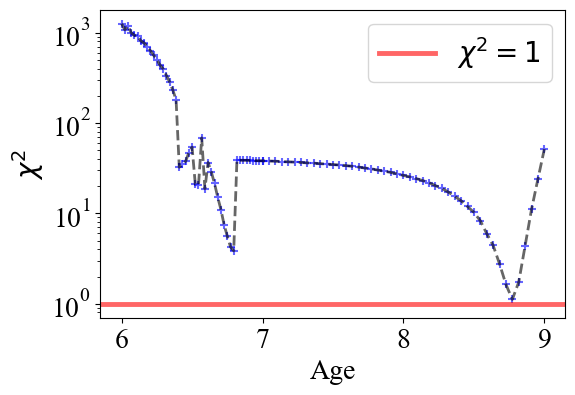

In [37]:
AgeList = []
for a in list(np.array(ResultArr)[:,1]):
    AgeList.append(a['age'].value)

plt.figure(figsize=(6,4))
plt.scatter(AgeList,list(np.array(ResultArr)[:,0]),alpha=0.6,marker="+",color="blue", lw=1.5)
plt.plot(AgeList,list(np.array(ResultArr)[:,0]),alpha=0.6,ls="--",color="black",lw=2)
plt.axhline(y=1,color="red",alpha=0.6, label=r"$\chi^2=1$")
plt.legend()
plt.yscale("log")
#plt.ylim(-0, 5)
plt.xlabel('Age')
plt.ylabel(r'$\chi^2$')
plt.savefig("%s/HD_%s_%s_best_chi.png"%(directory,target_hd,"m1andtot"), dpi=240, bbox_inches="tight")

In [38]:
## start with a chi2 fit (this does not always work)

## NOTE --> Since isochrones has a fixed age grid, the fitting currently fails to optimize this parameter
## We can search age on a grid, or change the default step size for the parameter

params = Parameters()
params.add('age',   value= 8.3)
params.add('mass1', value= 2.2)
params.add('mass2', value= 1.8)
params.add('feh', value = 0.25, vary=False)#, min=-0.5, max=0.5)

minner = Minimizer(isochrone_model_v2, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                         unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                         d_modulus.nominal_value, Av),nan_policy='omit')
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 10
    # variables        = 3
    chi-square         = 39.7389953
    reduced chi-square = 5.67699933
    Akaike info crit   = 19.7974786
    Bayesian info crit = 20.7052339
##  Warning: uncertainties could not be estimated:
    age:    at initial value
[[Variables]]
    age:    8.30000000 (init = 8.3)
    mass1:  2.46810733 (init = 2.2)
    mass2:  2.00273761 (init = 1.8)
    feh:    0.25 (fixed)


In [39]:
## Setup MCMC fit
starting_params = result.params.copy()
nwalkers = 2*len(starting_params)
steps = 5000
burn = 500
thin = 25

In [40]:
starting_params

name,value,initial value,min,max,vary
age,8.30000000,8.3,-inf,inf,True
mass1,2.46810733,2.2,-inf,inf,True
mass2,2.00273761,1.8,-inf,inf,True
feh,0.25000000,0.25,-inf,inf,False


In [41]:
d_Arr = np.linspace(distance.n-1*distance.s, distance.n+1*distance.s, 9)
feh_ARR = np.linspace(-0.15,0.15,7)

**Run Above**

In [ ]:
try:
    pass
    # os.remove("%s/HD_%s_D-FeH.csv"%(directory,target_hd))
except:
    pass

In [ ]:
# Write the data in a csv file
file = open("%s/HD_%s_D-FeH.csv"%(directory,target_hd), 'a')
writer = csv.writer(file)
header = ['FeH', 'Dmod', 'M_TOT', 'M_TOT_err', 'M_dyn', 'M_dyn_err']
writer.writerow(header)

In [ ]:
data = []
for d in d_Arr:
    for feh in feh_ARR:
        try:        
                dmod = 5*np.log10(d)-5

                a_rad = ufloat(float(df['a (mas)'][idx]),float(df['a_err (mas)'][idx]))/1000/206264.806247
                a_au = (d*a_rad)*206264.806
                P_yr = ufloat(float(df['P (yr)'][idx]),float(df['P_err (yr)'][idx]))
                M_dyn = a_au**3/P_yr**2 #M_dyn is an ufloat variable
                
                # Running MCMC on varying FeH and Distance Modulus

                emcee_params = starting_params.copy()
                emcee_params['feh'] = Parameter('feh', value=feh, vary=False)
                
                
                minner = Minimizer(isochrone_model_v2, emcee_params, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                                            unumpy.nominal_values(DiffM),
                                                                            unumpy.std_devs(TOT_Mag),
                                                                            unumpy.std_devs(DiffM),
                                                                            dmod, Av),
                                                                            nan_policy='omit')
                result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)

                # Writing result to the csv file
                mass1_best = ufloat(result.params['mass1'].value, result.params['mass1'].stderr)
                mass2_best = ufloat(result.params['mass2'].value, result.params['mass2'].stderr)
                mtot = mass1_best+mass2_best
                row = [feh, dmod, mtot.n, mtot.s, M_dyn.n, M_dyn.s]
                
                data.append(row)
        except:
            pass

In [ ]:
for r in data:
    writer.writerow(r)

In [ ]:
file.close()

In [42]:
M_df = pd.read_csv("%s/HD_%s_D-FeH.csv"%(directory,target_hd))
M_df

,FeH,Dmod,M_TOT,M_TOT_err,M_dyn,M_dyn_err
0,-0.15,4.703080,4.132543,0.038972,4.849634,0.014413
1,-0.10,4.703080,4.190056,0.040117,4.849634,0.014413
2,-0.05,4.703080,4.253101,0.041047,4.849634,0.014413
3,0.00,4.703080,4.314583,0.042882,4.849634,0.014413
4,0.05,4.703080,4.377482,0.045319,4.849634,0.014413
...,...,...,...,...,...,...
121,-0.05,4.736678,4.271695,0.042518,5.080047,0.015097
122,0.00,4.736678,4.331838,0.043910,5.080047,0.015097
123,0.05,4.736678,4.395518,0.043790,5.080047,0.015097
124,0.10,4.736678,4.463737,0.047453,5.080047,0.015097


In [43]:
M_dyn_range = np.unique(M_df['M_dyn'])
M_ph_range = np.unique(M_df['M_TOT'][:4])

In [ ]:
"""
matplotlib.rcParams['lines.linewidth'] = 3.5
i=0
for m in M_dyn_range:
    plt.axvline(x = m, lw=1.5, color='blue',alpha=0.4)
    plt.text(x=m-0.05, y=4.65+0.02*i,s="%.2f"% d_Arr[i],fontsize=12)
    i += 1

plt.text(x = M_dyn_range[0]-0.15, y = 4.65, s="d/pc = ", fontsize=12)

i = 0
for m in M_ph_range:
    plt.text(y=m-0.03, x=4.335,s="Fe/H=%.2f"% feh_ARR[i],fontsize=12)
    i += 1

plt.plot([4.22,5],[4.22,5], ls='--', color='#FFCB05', label=r"$M_{dyn} = M_{ph}$")
plt.errorbar(M_df['M_dyn'], M_df['M_TOT'], xerr=M_df['M_dyn_err'], yerr=M_df['M_TOT_err'], fmt="o", color='#00274C', alpha=0.5)
plt.legend()
plt.xlabel("Total Dynamical Mass")
plt.ylabel("Total Photometric Mass")

plt.title("Best-fit Photometric vs Dynamical Mass \nat Various Metallicities and Distances")

plt.savefig("%s/HD_%s_%s_Mph-Mdyn.png"%(directory,target_hd,"Chi"), dpi=240, bbox_inches="tight")
"""

In [44]:
M_df_large = pd.read_csv("%s/HD_%s_D-FeH_backup.csv"%(directory,target_hd))
M_dyn_range = np.unique(M_df_large['M_dyn'])
M_ph_range = np.unique(M_df_large['M_TOT'][:4])

In [45]:
M_dyn_range[2] - M_dyn_range[1]

0.11079180270670097

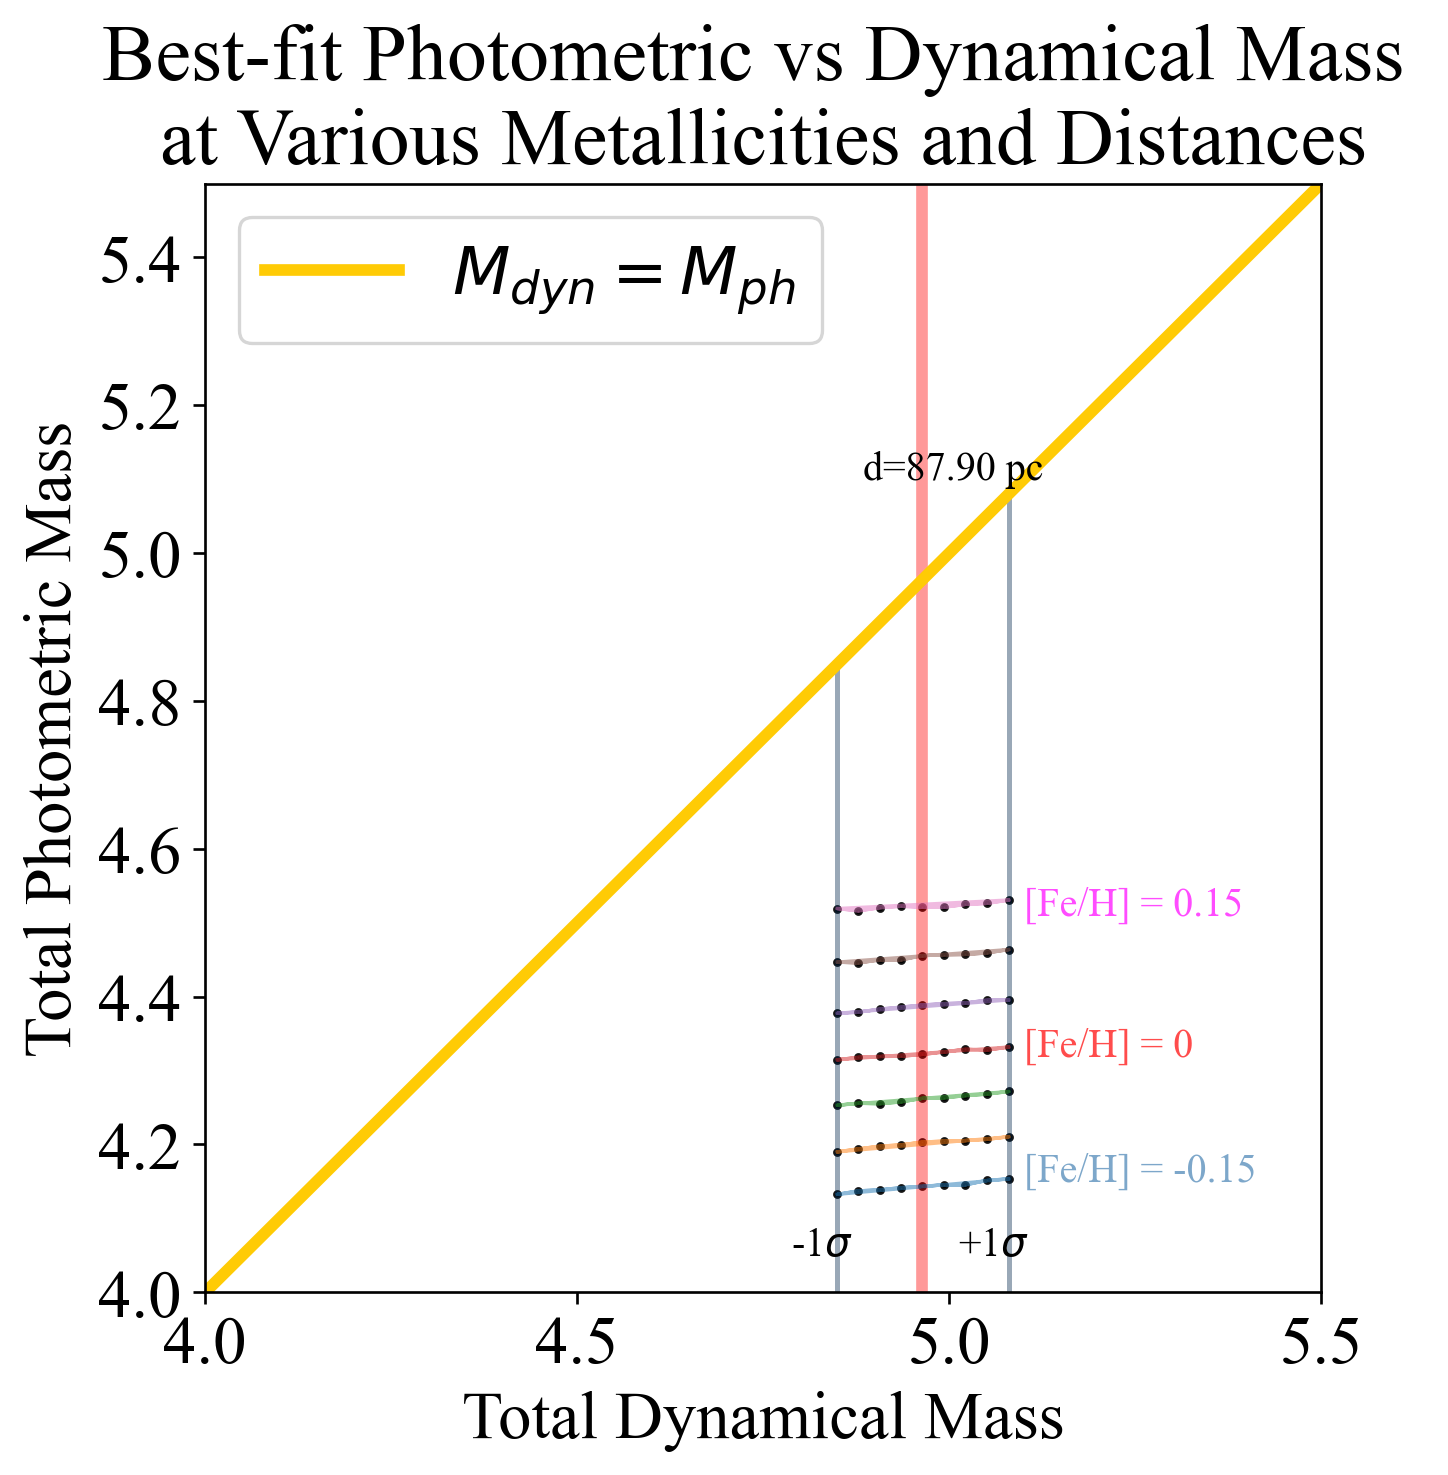

In [46]:
plt.figure(figsize=(6,6),dpi=240,facecolor="None")
# plt.errorbar(M_df['M_dyn'], M_df['M_TOT'], xerr=M_df['M_dyn_err'], yerr=M_df['M_TOT_err'], lw=1.5, marker="2", fmt=".", alpha=0.3)

i=0
for m in M_dyn_range:
    plt.axvline(x = m, ymin=0, ymax=1-(5.5-m)/1.5, lw=1.5, color='#00274C',alpha=[0,0,0,0.4,0,0.4,0,0,0][i])
    i += 1

plt.axvline(x=M_dyn_range[4], color="red", alpha=0.4)

plt.plot([3,5.5], [3,5.5], label=r"$M_{dyn} = M_{ph}$", color = "#FFCB05")

plt.text(x=M_dyn_range[4]-0.08, y=5.1,s="d=%.2f pc"% d_Arr[4],fontsize=12)
plt.text(x=5.1, y=4.51, s="[Fe/H] = 0.15",fontsize=12, color="magenta", alpha=0.7)
plt.text(x=5.1, y=4.32, s="[Fe/H] = 0",fontsize=12, color="red", alpha=0.7)
plt.text(x=5.1, y=4.15, s="[Fe/H] = -0.15",fontsize=12, color="steelblue", alpha=0.7)

for feh in [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]:
    df_new = M_df[M_df['FeH']==feh]
    plt.plot(df_new['M_dyn'], df_new['M_TOT'], lw=1, alpha=0.5)

plt.scatter(M_df['M_dyn'], M_df['M_TOT'],marker=".", s=10, color="black", alpha=0.7)
plt.ylim(4,5.5)
plt.xlim(4,5.5)
plt.legend()
plt.xlabel("Total Dynamical Mass")
plt.ylabel("Total Photometric Mass")

for i in range(1,2):
    plt.text(x=4.9+i*0.1120, y=4.05, s=f"+{i}"+r"$\sigma$", fontsize=12)
    plt.text(x=4.9-i*0.1120, y=4.05, s=f"-{i}"+r"$\sigma$", fontsize=12)



plt.title("Best-fit Photometric vs Dynamical Mass \nat Various Metallicities and Distances")

plt.savefig("%s/HD_%s_%s_Mph-Mdyn.png"%(directory,target_hd,"Chi"), dpi=240, bbox_inches="tight")

In [ ]:
M_df['M_TOT']

In [ ]:
import seaborn
g = seaborn.relplot(
    x=M_df['M_dyn'], y=M_df['M_TOT'], sizes=(10, 200),
)

**As there might be point missing on the when running the MCMC above, we manually fix it below.**

In [ ]:
# Fixing the missing points manually
feh=-0.8
d_ind = 4
emcee_params = starting_params.copy()
emcee_params['feh'] = Parameter('feh', value=feh, vary=False)
emcee_params['mass1'] = Parameter('mass1', value=2.3)
emcee_params['mass2'] = Parameter('mass2', value=1.8)
emcee_params['age'] = Parameter('age', value=8.7)
dmod = 5*np.log10(d_Arr[d_ind])-5

a_rad = ufloat(float(df['a (mas)'][idx]),float(df['a_err (mas)'][idx]))/1000/206264.806247
a_au = (d_Arr[d_ind]*a_rad)*206264.806
P_yr = ufloat(float(df['P (yr)'][idx]),float(df['P_err (yr)'][idx]))
M_dyn = a_au**3/P_yr**2 #M_dyn is an ufloat variable

## Setup MCMC fit
nwalkers = 2*len(starting_params)
steps = 10000
burn = 500
thin = 25

In [ ]:
## Do MCMC fit (this cell could take some time, depending on steps)
np.random.seed(5)
minner = Minimizer(isochrone_model_v2, emcee_params, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            dmod, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))



In [ ]:
mass1_best = ufloat(result.params['mass1'].value, result.params['mass1'].stderr)
mass2_best = ufloat(result.params['mass2'].value, result.params['mass2'].stderr)
mtot = mass1_best+mass2_best
row = [feh, dmod, mtot.n, mtot.s, M_dyn.n, M_dyn.s]
row

In [ ]:
file = open("%s/HD_%s_D-FeH.csv"%(directory,target_hd), 'a')
writer = csv.writer(file)

In [ ]:
writer.writerow(row)
file.close()

## We generate MCMC Corner plot in this part

In [52]:
# Fixing the missing points manually
feh=-0.46
d_ind = 4
emcee_params = starting_params.copy()
emcee_params['feh'] = Parameter('feh', value=feh, vary=False)
emcee_params['mass1'] = Parameter('mass1', value=2.3)
emcee_params['mass2'] = Parameter('mass2', value=1.8)
emcee_params['age'] = Parameter('age', value=8.7)
dmod = 5*np.log10(d_Arr[d_ind])-5

a_rad = ufloat(float(df['a (mas)'][idx]),float(df['a_err (mas)'][idx]))/1000/206264.806247
a_au = (d_Arr[d_ind]*a_rad)*206264.806
P_yr = ufloat(float(df['P (yr)'][idx]),float(df['P_err (yr)'][idx]))
M_dyn = a_au**3/P_yr**2 #M_dyn is an ufloat variable

## Setup MCMC fit
nwalkers = 6*len(starting_params)
steps = 30000
burn = 2000
thin = 50

In [54]:
nwalkers

24

In [55]:
## Do MCMC fit (this cell could take some time, depending on steps)
np.random.seed(19)
minner = Minimizer(isochrone_model_v2, emcee_params, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            dmod, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))

100%|██████████| 30000/30000 [09:09<00:00, 54.62it/s]


[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 720000
    # data points      = 10
    # variables        = 3
    chi-square         = 9.12670386
    reduced chi-square = 1.30381484
    Akaike info crit   = 5.08619513
    Bayesian info crit = 5.99395041
[[Variables]]
    age:    8.77074753 +/- 0.02224932 (0.25%) (init = 8.7)
    mass1:  2.04854735 +/- 0.02248717 (1.10%) (init = 2.3)
    mass2:  1.78456304 +/- 0.01990029 (1.12%) (init = 1.8)
    feh:   -0.46 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(age, mass1) = -0.915
    C(age, mass2) = -0.344
None


In [56]:
mass1_best = ufloat(result.params['mass1'].value, result.params['mass1'].stderr)
mass2_best = ufloat(result.params['mass2'].value, result.params['mass2'].stderr)
mtot = mass1_best+mass2_best
row = [feh, dmod, mtot.n, mtot.s, M_dyn.n, M_dyn.s]
row

[-0.46,
 4.7199443753688595,
 3.8331103837868548,
 0.030028227364790445,
 4.963948908177386,
 0.014752346458991117]

#### Now let's plot some MCMC outputs
##### Need to make more plots to check convergence, etc

In [57]:
chains = result.flatchain

## save chains (so we don't need to run large ones again)
print(chains.shape)
np.save("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"final_fixedFeH"),chains)

(13440, 3)


In [58]:
## load chains -- NOTE: Could start from here if a run has already been completed
chains = np.load("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"final_fixedFeH"))
matplotlib.rcParams['lines.linewidth'] = 1.5

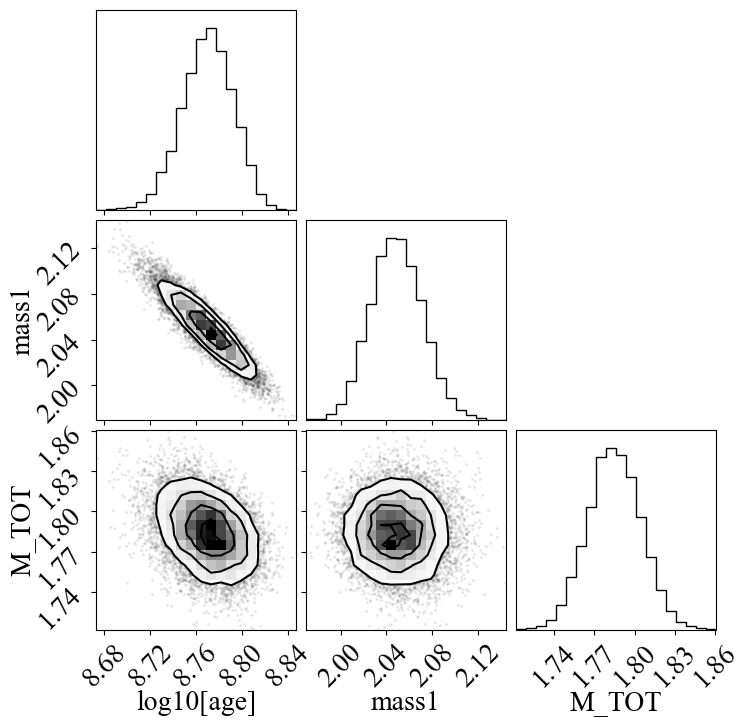

In [59]:
try:
    emcee_plot = corner.corner(chains,labels=['log10[age]', 'mass1', 'M_TOT'],linewidth=1)
    plt.savefig('%s/HD_%s_%s_corner.jpg'%(directory,target_hd,"final_fixedFeH"))
except:
    print(result.var_names)
    emcee_plot = corner.corner(chains)
    plt.savefig('%s/HD_%s_%s_corner.png'%(directory,target_hd,"final_fixedFeH"))

In [60]:
best_M = ufloat(3.83724307, 0.04128422)
Mdiff = (M_dyn - best_M).n
Mdiff_e = (M_dyn - best_M).s
print("Difference in mass: %.4f +/- %.4f" %(Mdiff,Mdiff_e))

Difference in mass: 1.1267 +/- 0.0438


#### Compute best model to make plots

In [ ]:
chains

In [68]:
#age_chain = np.array(chains["age"])
#mass1_chain = np.array(chains['mass1'])
#mass2_chain = np.array(chains["mass2"])

age_chain = chains[:,0]
mass1_chain = chains[:,1]
mass2_chain = chains[:,2]
#feh_chain = np.array(chains["feh"])

age_best = np.mean(age_chain)
mass1_best = np.mean(mass1_chain)
mass2_best = np.mean(mass2_chain)
#feh_best = np.mean(feh_chain)

age_err = np.std(age_chain)
mass1_err = np.std(mass1_chain)
mass2_err = np.std(mass2_chain)
#feh_err = np.std(feh_chain)


In [69]:
age = ufloat(age_best,age_err)
mass1 = ufloat(mass1_best,mass1_err)
mass2 = ufloat(mass2_best,mass2_err)
feh = -0.46

In [70]:
print('Log Age = ', age)
print('M1 (solar) = ', mass1)
print('M2 (solar) = ', mass2-mass1)
print('Msum (solar) = ', mass2)

Log Age =  8.770+/-0.022
M1 (solar) =  2.049+/-0.022
M2 (solar) =  -0.265+/-0.030
Msum (solar) =  1.785+/-0.020


In [71]:
mass2

1.7846961699096726+/-0.01953666047808479

In [72]:
mass2 - M_dyn

-3.1792527382677136+/-0.1177766437263111

In [73]:
a1_best = tracks.generate(mass1_best, age_best, feh, return_dict=True)
a2_best = tracks.generate(mass2_best, age_best, feh, return_dict=True)

#if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
#    return np.inf
    
model1 = np.array([(a1_best['Mbol'] - bc_grid_U.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                           (a1_best['Mbol'] - bc_grid_B.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_V.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_R.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0], 
                      (a1_best['Mbol'] - bc_grid_I.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_J.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus)[0],
                      a1_best["H_mag"]+d_modulus,
                      a1_best["K_mag"]+d_modulus])

model2 = np.array([(a2_best['Mbol'] - bc_grid_U.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                        (a2_best['Mbol'] - bc_grid_B.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_V.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_R.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_I.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_J.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus)[0],
                      a2_best["H_mag"]+d_modulus,
                      a2_best["K_mag"]+d_modulus])

In [74]:
model1+model2

array([12.120991408675048+/-0.033597297803664536,
       12.171857142951243+/-0.033597297803664536,
       12.151884356044047+/-0.033597297803664536,
       12.154837525092528+/-0.033597297803664536,
       12.160561990734482+/-0.033597297803664536,
       12.17876361477028+/-0.033597297803664536,
       12.184087964259582+/-0.033597297803664536,
       12.186850240540842+/-0.033597297803664536], dtype=object)

In [75]:
model_TOT = -2.5*np.log10(10**(-0.4*unumpy.nominal_values(model1))+10**(-0.4*unumpy.nominal_values(model2)))
model_Diff = unumpy.nominal_values(model2-model1)

In [76]:
unumpy.nominal_values(TOT_Mag),unumpy.nominal_values(DiffM),unumpy.std_devs(TOT_Mag),unumpy.std_devs(DiffM)

(array([5.26000023, 5.26300001, 5.27299976,        nan,        nan,
        5.24300003, 5.30100012, 5.26499987]),
 array([0.88, 0.81, 0.7 , 0.8 , 0.43]),
 array([  nan, 0.014, 0.009,   nan,   nan, 0.046, 0.021, 0.027]),
 array([0.22, 0.15, 0.15, 0.19, 0.1 ]))

In [77]:
x_noG = np.array([2190,1630,1220,832,658,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above

In [78]:
matplotlib.rcParams["lines.linewidth"] = 3.5

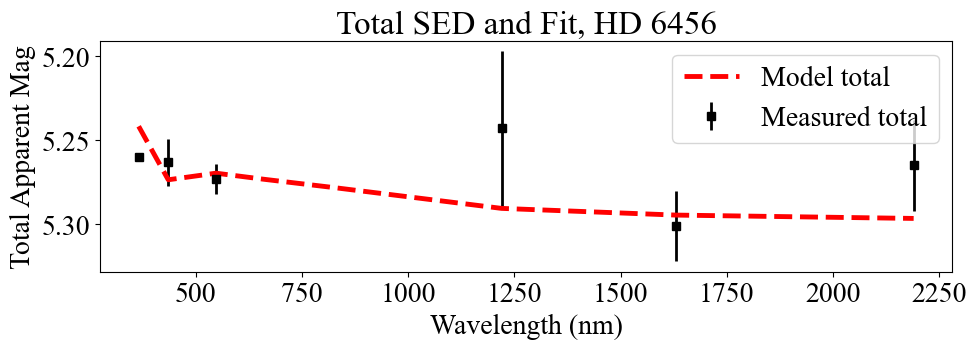

In [85]:
## SED plot with best fit
plt.figure(figsize=(11,3), facecolor="None")
plt.title("Total SED and Fit, HD %s"%target_hd)
plt.errorbar(np.flip(x_noG), unumpy.nominal_values(TOT_Mag), yerr = unumpy.std_devs(TOT_Mag), fmt='s',color='black', label="Measured total", lw=2)

plt.plot(np.flip(x_noG), model_TOT, '--', color='red', label="Model total")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Total Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_totMag_fit.pdf"%(directory,target_hd,"m1andtot"), dpi=240,  bbox_inches="tight")
plt.show()

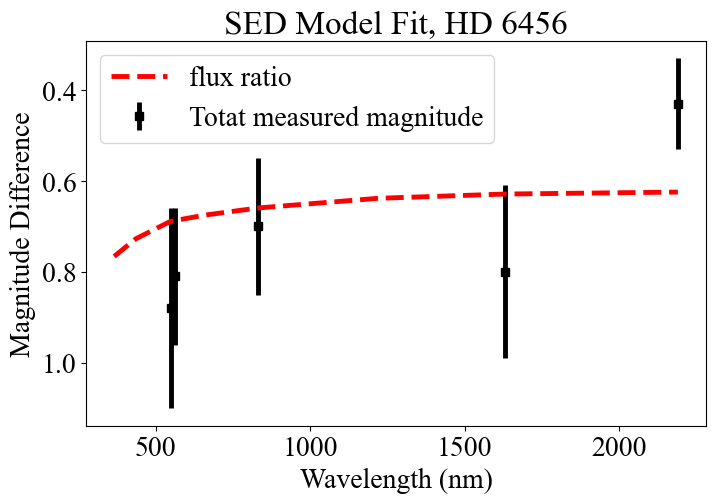

In [81]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(data_wave,unumpy.nominal_values(DiffM),yerr = unumpy.std_devs(DiffM), fmt='s',color='black', label="Totat measured magnitude")

plt.plot(np.flip(x_noG),model_Diff,'--',color='red', label="flux ratio")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude Difference')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_diffMag_fit.pdf"%(directory,target_hd,"m1andtot"))
plt.show()

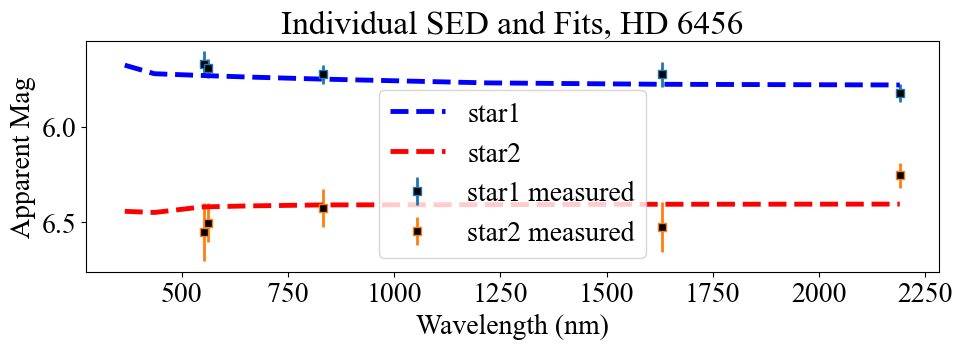

In [87]:
# Individual SEDs
plt.figure(figsize=(11,3), facecolor="None")
plt.title("Individual SED and Fits, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='s', label="star1 measured", lw=2)
plt.errorbar(data_wave,p2,p2err,fmt='s', label="star2 measured", lw=2)

plt.plot(np.flip(x_noG),unumpy.nominal_values(model1),'--',color='blue', label="star1")
plt.plot(np.flip(x_noG),unumpy.nominal_values(model2),'--',color='red', label="star2")

plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.png"%(directory,target_hd,"m1andtot"), dpi=240,  bbox_inches="tight")
plt.show()

## Chi-Square surface of varying $[\text{Fe/H}]$

In [ ]:
def redChi(Chi):
    return np.nansum(Chi**2)/(np.sum(~np.isnan(Chi))-3)

In [42]:
chiparams = result.params.copy()
chiparams

name,value,initial value,min,max,vary
age,8.30000000,8.3,-inf,inf,True
mass1,2.46810733,2.2,-inf,inf,True
mass2,2.00273761,1.8,-inf,inf,True
feh,0.25000000,0.25,-inf,inf,False


In [ ]:
chiGrid = []

i = 0
for m2 in np.linspace(3,4.5,50):
    chiGrid.append([])
    for feh in np.linspace(-0.5,0,50):
        chiparams['feh'] = Parameter(name='feh', value=feh)
        chiparams['mass2'] = Parameter(name='age', value=m2)

        Chi = isochrone_model_v3_II(chiparams, unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                            unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                            d_modulus.nominal_value, Av)

        chiGrid[i].append(redChi(Chi))
    i += 1

In [ ]:
logChiGrid = np.log10(np.array(chiGrid))

In [ ]:
np.min(chiGrid)

In [ ]:
X, Y = np.meshgrid(np.linspace(-0.5,0.5,50), np.linspace(3,4.5,50))

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
ax.contourf(X, Y, logChiGrid)

In [ ]:
plt.contourf(X,Y,logChiGrid, cmap=cm.Blues)
plt.colorbar()
plt.xlabel("FeH", fontdict=font)
plt.ylabel("log[Age]", fontdict=font)
plt.title(r"$\log_{10}\chi^2$ surface", fontdict=font)
plt.ylim(3.6,4)
plt.savefig("%s/HD_%s_%s_chi2_surface.pdf"%(directory,target_hd,note))

In [ ]:
plt.contourf(X,Y,logChiGrid, cmap=cm.Blues)
plt.colorbar()
plt.xlabel("FeH", fontdict=font)
plt.ylabel(r"Total Mass/$M_\odot$", fontdict=font)
plt.title(r"$\log_{10}\chi^2$ surface", fontdict=font)
plt.ylim(3,4.5)
plt.savefig("%s/HD_%s_%s_chi2_surface_full.pdf"%(directory,target_hd,note))

### We investigate of best-fit chi when varying FeH. Fixed age.

### Now we run a MCMC with varying FeH

In [45]:
np.random.seed(1)
emcee_params_2 = chiparams.copy()
emcee_params_2['feh'] = Parameter('feh', value=-0.46, min=-1, max=1)
emcee_params_2['age'] = Parameter('age', value=8.7)
nwalkers = 6*len(emcee_params_2)
steps = 30000
burn = 2000
thin = 20

In [46]:
emcee_params_2

name,value,initial value,min,max,vary
age,8.70000000,8.7,-inf,inf,True
mass1,2.46810733,2.2,-inf,inf,True
mass2,2.00273761,1.8,-inf,inf,True
feh,-0.46000000,-0.46,-1.00000000,1.00000000,True


In [47]:
minner = Minimizer(isochrone_model_v2, emcee_params_2, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))

100%|██████████| 30000/30000 [09:05<00:00, 55.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1103.56275854 1208.1050146  1019.48008041 1250.9971152 ]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 720000
    # data points      = 10
    # variables        = 4
    chi-square         = 12.4221579
    reduced chi-square = 2.07035964
    Akaike info crit   = 10.1689671
    Bayesian info crit = 11.3793075
[[Variables]]
    age:    7.70798205 +/- 0.52246257 (6.78%) (init = 8.7)
    mass1:  2.60561902 +/- 0.10628034 (4.08%) (init = 2.468107)
    mass2:  1.99980637 +/- 0.05168934 (2.58%) (init = 2.002738)
    feh:    0.21993731 +/- 0.10439550 (47.47%) (init = -0.46)
[[Correlations]] (unreported correlations are < 0.100)
    C(mass1, feh)   = 0.920
    C(age, mass1)   = -0.870
    C(mass2, feh)   = 0.837
    C(age, feh)     = -0.731
    C(mass1, mass2) = 0.667
    C(age, mass2)   = -0.535
None


In [48]:
chains_vary_feh = result.flatchain

## save chains (so we don't need to run large ones again)
print(chains_vary_feh.shape)
np.save("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"vary_FeH"),chains_vary_feh)

(33600, 4)


In [49]:
## load chains -- NOTE: Could start from here if a run has already been completed
chains_vary_feh = np.load("%s/HD_%s_%s_chains.npy"%(directory,target_hd,"vary_FeH"))

In [ ]:
result.var_names

In [ ]:
try:
    emcee_plot = corner.corner(chains_vary_feh,labels=[r'$\log 10$[Age]', 'mass1', 'M_TOT', 'FeH'],fontdict=font)
    plt.savefig('%s/HD_%s_%s_corner.jpg'%(directory,target_hd,"vary_FeH"))
except:
    print(result.var_names)
    emcee_plot = corner.corner(chains_vary_feh)
    #plt.savefig('%s/HD_%s_%s_corner.png'%(directory,target_hd,"vary_FeH"))

In [ ]:
age_chain = chains_vary_feh[:,0]
mass1_chain = chains_vary_feh[:,1]
mass2_chain = chains_vary_feh[:,2]
feh_chain = chains_vary_feh[:,3]

age_best = np.mean(age_chain)
mass1_best = np.mean(mass1_chain)
mass2_best = np.mean(mass2_chain)
feh_best = np.mean(feh_chain)

age_err = np.std(age_chain)
mass1_err = np.std(mass1_chain)
mass2_err = np.std(mass2_chain)
feh_err = np.std(feh_chain)


In [ ]:
age_best = 7.72225
mass1_best = 2.60515
mass2_best = 4.62825
feh_best = 0.22707816 

In [ ]:
age = ufloat(age_best,age_err)
mass1 = ufloat(mass1_best,mass1_err)
mass2 = ufloat(mass2_best,mass2_err)
feh = ufloat(feh_best,feh_err)
print('Log Age = ', age)
print('M1 (solar) = ', mass1)
print('M2 (solar) = ', mass2-mass1)
print('Msum (solar) = ', mass2)

In [ ]:
a1_best = tracks.generate(mass1_best, age_best, feh_best, return_dict=True)
a2_best = tracks.generate(mass2_best-mass1_best, age_best, feh_best, return_dict=True)

#if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
#    return np.inf
    
model1 = np.array([(a1_best['Mbol'] - bc_grid_U.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                           (a1_best['Mbol'] - bc_grid_B.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_V.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_R.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0], 
                      (a1_best['Mbol'] - bc_grid_I.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a1_best['Mbol'] - bc_grid_J.interp([a1_best['Teff'], a1_best['logg'], feh_best, Av ])+d_modulus)[0],
                      a1_best["H_mag"]+d_modulus,
                      a1_best["K_mag"]+d_modulus])

model2 = np.array([(a2_best['Mbol'] - bc_grid_U.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                        (a2_best['Mbol'] - bc_grid_B.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_V.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_R.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_I.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      (a2_best['Mbol'] - bc_grid_J.interp([a2_best['Teff'], a2_best['logg'], feh_best, Av ])+d_modulus)[0],
                      a2_best["H_mag"]+d_modulus,
                      a2_best["K_mag"]+d_modulus])

In [ ]:
model_TOT = -2.5*np.log10(10**(-0.4*unumpy.nominal_values(model1))+10**(-0.4*unumpy.nominal_values(model2)))-d_modulus.n
model_Diff = unumpy.nominal_values(model2-model1)

In [ ]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(np.flip(x_noG), unumpy.nominal_values(TOT_Mag), yerr = unumpy.std_devs(TOT_Mag), fmt='o--',color='black')

plt.plot(np.flip(x_noG), model_TOT, '--', color='red', label="Total Magnitudes")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Total Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_totMag_fit.pdf"%(directory,target_hd,"vary_FeH"))
plt.show()

In [ ]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(data_wave,unumpy.nominal_values(DiffM),yerr = unumpy.std_devs(DiffM), fmt='o--',color='black')

plt.plot(np.flip(x_noG),model_Diff,'--',color='red', label="flux ratio")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude Difference')
plt.gca().invert_yaxis()
# plt.savefig("%s/HD_%s_%s_diffMag_fit.pdf"%(directory,target_hd,note))
plt.show()

In [ ]:
# Individual SEDs
plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')

plt.plot(np.flip(x_noG),unumpy.nominal_values(model1),'--',color='blue', label="star1")
plt.plot(np.flip(x_noG),unumpy.nominal_values(model2),'--',color='red', label="star2")

plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,"vary_FeH"))
plt.show()

In [ ]:
d_modulus